<a href="https://colab.research.google.com/github/aderdouri/ql_web_app/blob/master/ql_notebooks/a_glitch_in_forward_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A glitch in forward-rate curves

(Based on [a question asked by Boris Chow](https://sourceforge.net/p/quantlib/mailman/message/34286980/) on the QuantLib mailing list. Thanks!)

In [ ]:
!pip install QuantLib-Python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 71.0 MB/s eta 0:00:00


In [ ]:
import urllib.request
import importlib.util
import sys

# URL of the Python file
url = 'https://raw.githubusercontent.com/aderdouri/ql_web_app/master/ql_notebooks/utils.py'

# Download the file
urllib.request.urlretrieve(url, 'utils.py')

# Import the module
spec = importlib.util.spec_from_file_location("utils", "utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["utils"] = utils
spec.loader.exec_module(utils)

In [ ]:
%matplotlib inline
from pandas import DataFrame
import numpy as np
import utils

In [ ]:
import QuantLib as ql

In [ ]:
today = ql.Date(24, ql.August, 2015)
ql.Settings.instance().evaluationDate = today

#### The statement of the case

Let's say we have built an interpolated forward-rate curve, by which I mean that it interpolates instantaneous forward rates (for more details, read my other book). We're using a backward-flat interpolation, which corresponds to log-linear discount factors. The dates and forwards are entirely made up; they are just for show.

In [ ]:
dates = [ today ] + [ today + ql.Period(i, ql.Years)
                      for i in [1, 2, 3, 5, 10, 20] ]
forwards = [ 0.01, 0.03, 0.02, 0.025, 0.035, 0.05, 0.04 ]
curve = ql.ForwardCurve(dates, forwards, ql.Actual360())

We can ask the curve for its nodes, and it will return those we expect&mdash;that is, those we passed ourselves...

In [ ]:
DataFrame(list(curve.nodes()),
          columns = ('date','rate'),
          index = ['']*len(dates))

,date,rate
,"August 24th, 2015",0.010
,"August 24th, 2016",0.030
,"August 24th, 2017",0.020
,"August 24th, 2018",0.025
,"August 24th, 2020",0.035
,"August 24th, 2025",0.050
,"August 24th, 2035",0.040


...and if we retrieve the instantaneous forward from a date between the nodes, it's the same as that of the following node, as expected for a backward-flat interpolation.

In [ ]:
d = today + ql.Period(4,ql.Years)
print(d)
print(curve.forwardRate(d, d, curve.dayCounter(), ql.Continuous))

August 24th, 2019
3.500000 % Actual/360 continuous compounding


We can even plot the whole thing and get the expected shape.

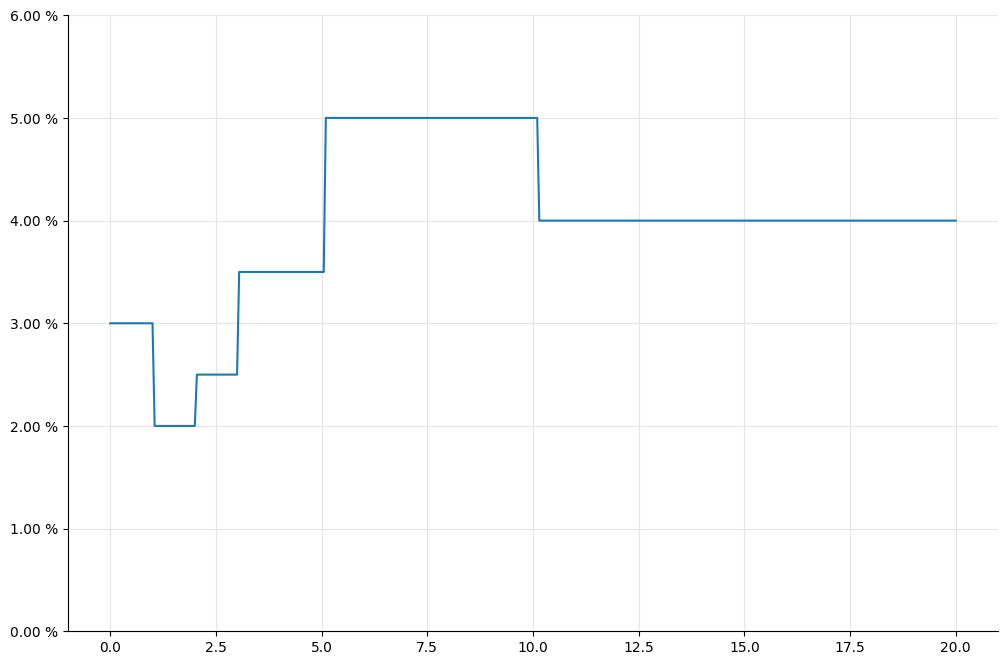

In [ ]:
sample_times = np.linspace(0.0, 20.0, 401)
sample_rates = [ curve.forwardRate(t, t, ql.Continuous).rate()
                 for t in sample_times ]

f, ax = utils.plot()
ax.set_ylim(0.0,0.06)
ax.yaxis.set_major_formatter(utils.rate_formatter())
ax.plot(sample_times, sample_rates);

So it seems all is well with the world. What if we retrieve the instantaneous forward rates at the curve nodes, though?

In [ ]:
dates, expected = zip(*curve.nodes())
rates = [ curve.forwardRate(d, d, curve.dayCounter(), ql.Continuous).rate()
          for d in dates]
DataFrame(list(zip(dates, expected, rates)),
          columns = ('date','expected','retrieved'),
          index = ['']*len(dates))

,date,expected,retrieved
,"August 24th, 2015",0.010,0.0300
,"August 24th, 2016",0.030,0.0250
,"August 24th, 2017",0.020,0.0225
,"August 24th, 2018",0.025,0.0300
,"August 24th, 2020",0.035,0.0425
,"August 24th, 2025",0.050,0.0450
,"August 24th, 2035",0.040,0.0400


Here are the above points, together with the rest of the curve.

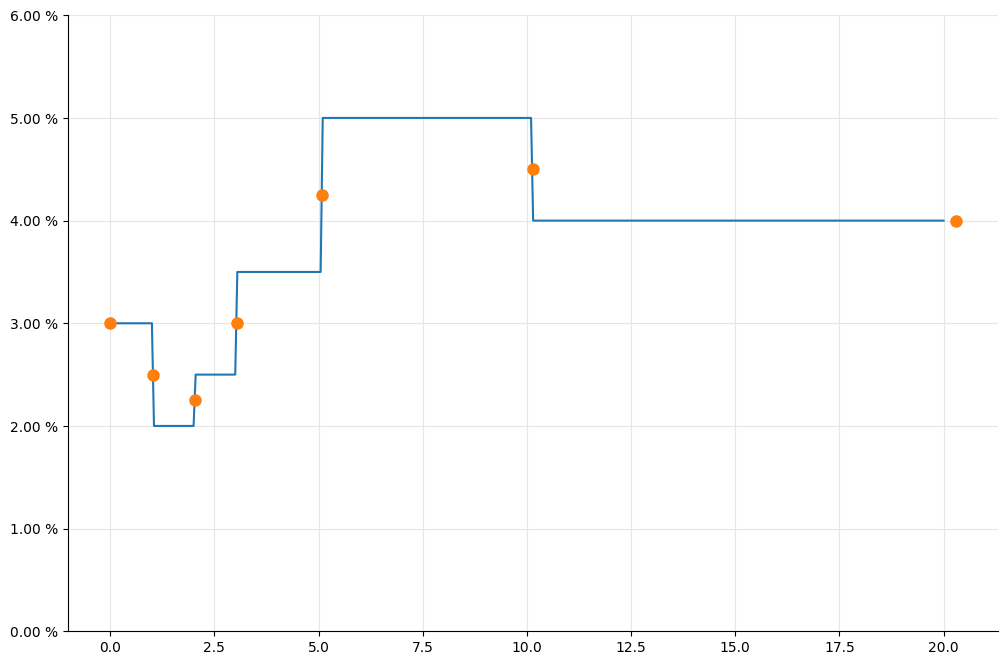

In [ ]:
node_times = [ curve.dayCounter().yearFraction(today, d) for d in dates ]
ax.plot(node_times, rates, 'o', markersize=8)
display(f)

#### What's wrong?

It's a combination of two things. First, the particular interpolation we've chosen causes the instantaneous forwards to be discontinuous at the nodes. Second, there's a limitation in the implementation of the base `TermStructure` class: the instantaneous forwards are not taken directly from the interpolation, but retrieved generically from the discount factors as the forward over a small interval around the given time; that is,

$$
\tilde{f}(t) = \frac{1}{2 \delta t} \log\left(\frac{B(t-\delta t)}{B(t+\delta t)}\right)
$$

Again, the details are in my other book.

By writing the discount factors $B(t)$ in terms of the zero rates as $\exp\left(Z(t) \cdot t \right)$, and in turn the zero rates in terms of the instantaneous forwards as $Z(t) = \displaystyle{\int_0^t f(\tau) d\tau}$, the above simplifies (well, for some value of "simplifies") to

$$
\tilde{f}(t) = \frac{1}{2 \delta t} \left[ \int_0^{t+\delta t} f(\tau) d\tau - \int_0^{t-\delta t} f(\tau) d\tau \right]
$$

We can interpret the above expression in two ways; both explain why the values at the nodes are off and why we get the correct values elsewhere.

As the difference of two integrals, it equals

$$
\frac{1}{2 \delta t} \left[ \int_{t-\delta t}^{t+\delta t} f(\tau) d\tau \right]
$$

that is, the average of $f(\tau)$ between $t-\delta t$ and $t+\delta t$. What this means is clear from the following figure: off the nodes, the result equals the flat value of the forwards; at the nodes, though, it equals the average between the two adjacent levels.

If we consider the integral $\displaystyle{\int_0^t f(\tau) d\tau}$ as a function $F(t)$ instead, $\tilde{f}(t)$ equals $\displaystyle{\frac{F(t+\delta t)-F(t-\delta t)}{2 \delta t}}$; that is, the numerical derivative of $F$ at $t$. Again, a figure shows clearly what happens at and off the nodes: the forwards are piecewise flat, their integral is piecewise linear with slopes equal to the forwards, and the derivative at a given node is in between the two joining slopes.

#### Is the curve wrong, then?

Yes and no. The glitch above is real, but discount factors and discrete rates are retrieved correctly so there's no problem using the curve (unless the value of an instrument depends on instantaneous forwards, but that's unlikely). If the above troubles you, though, what you can do is simply to choose another interpolation that doesn't cause discontinuities.